# Beta Bank Customer Churn Prediction Project

The objective of this project is to develop a machine learning model that predicts customer churn for Beta Bank using structured customer data. Churn, defined as a customer exiting the bank, represents a significant business concern due to the high cost of acquisition compared to retention. This project investigates patterns in customer demographics and behavior to identify key drivers of churn and enable targeted intervention strategies. 

Our working hypotheses include: 
(1) older and inactive customers are more likely to churn,
(2) customers with fewer bank products or lower engagement levels exhibit higher churn risk, and 
(3) regional differences exist in churn behavior, possibly due to socioeconomic or service level factors. 

By combining exploratory data analysis with a Random Forest classifier and class balancing techniques, this project aims to build an interpretable model with a high F1 score, prioritizing the ability to correctly identify churners.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Dataset
print("Loading data")
df = pd.read_csv("Churn.csv")
df.head()

Loading data


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#Basic Cleaning

print("\nChecking for duplicates and missing values")
print(f"Duplicate rows: {df.duplicated().sum()}")
print("\nMissing values:")
print(df.isnull().sum())

print("\nDropping irrelevant columns and filling missing tenure")
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
df['Tenure'] = df['Tenure'].fillna(0)
df.head()


Checking for duplicates and missing values
Duplicate rows: 0

Missing values:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Dropping irrelevant columns and filling missing tenure


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Class distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64


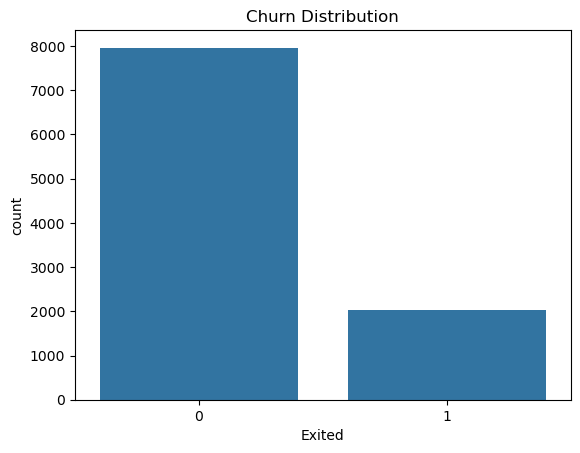

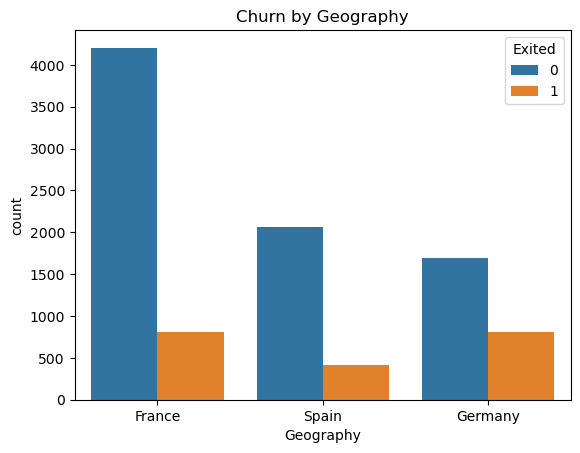

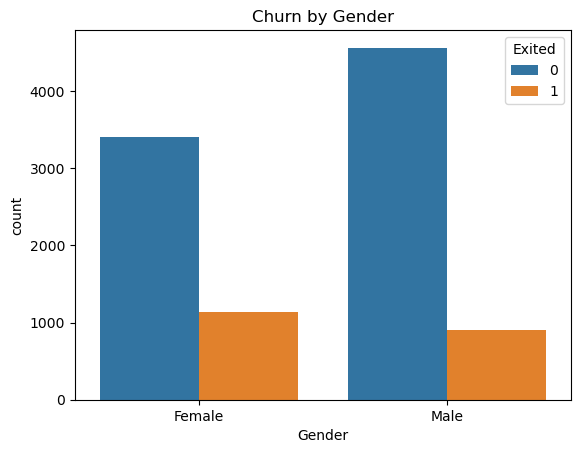

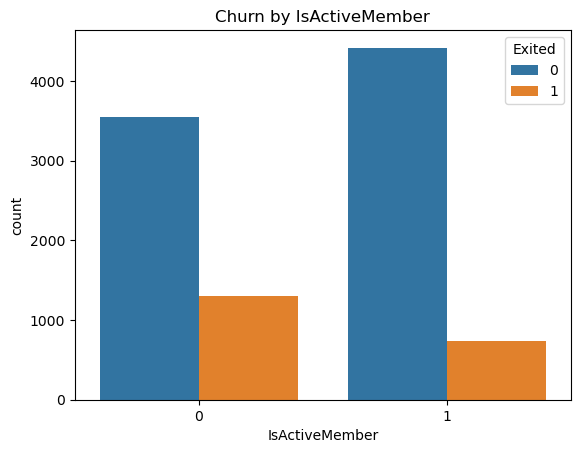

In [4]:
# Exploratory Data Analysis (EDA)
print("\nClass distribution:")
print(df['Exited'].value_counts())
sns.countplot(data=df, x='Exited')
plt.title('Churn Distribution')
plt.show()

# Categorical relationships
for col in ['Geography', 'Gender', 'IsActiveMember']:
    sns.countplot(data=df, x=col, hue='Exited')
    plt.title(f'Churn by {col}')
    plt.show()


The target variable (Exited) is imbalanced, with the majority class representing non churned customers. Count plots across categorical features revealed significant variation in churn rates by Geography, indicating possible regional behavioral differences. IsActiveMember showed a strong relationship with churn customers marked as inactive exhibited a higher likelihood of exiting. In contrast, the Gender variable did not display a pronounced impact on churn distribution. These patterns suggest potential predictive value in regional and engagement-based features, which guided feature engineering and model prioritization.

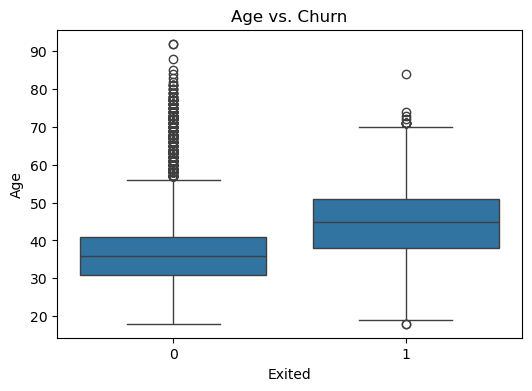

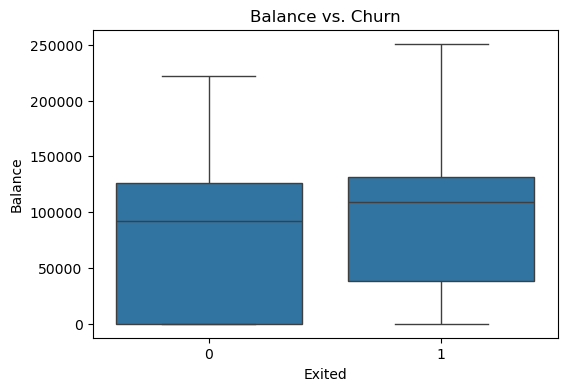

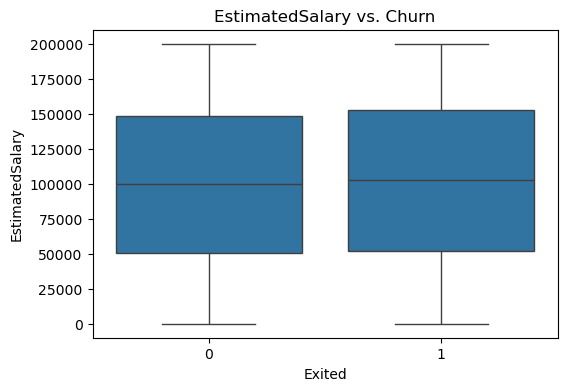

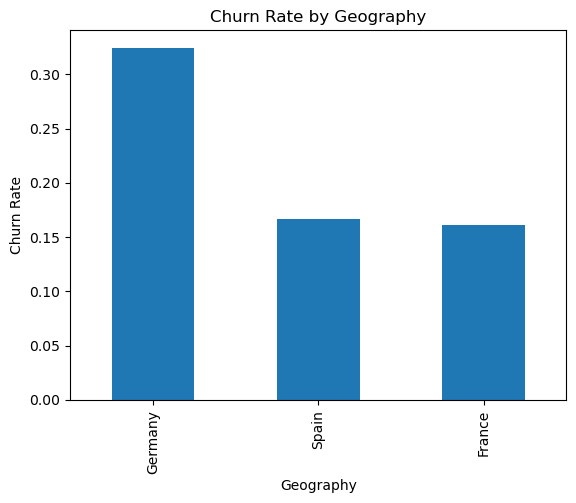

In [5]:
# Boxplots of numeric features by churn
num_features = ['Age', 'Balance', 'EstimatedSalary']
for col in num_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f'{col} vs. Churn')
    plt.show()

# Churn rate by geography
churn_by_geo = df.groupby('Geography')['Exited'].mean().sort_values(ascending=False)
churn_by_geo.plot(kind='bar', title='Churn Rate by Geography')
plt.ylabel('Churn Rate')
plt.show()

Boxplot analysis of numerical features revealed that customers who churned tended to be older on average compared to those who remained. While Balance and EstimatedSalary displayed wide variability, no clear median shift was observed between churned and retained groups, suggesting limited predictive power in isolation. However, regional analysis of churn rates highlighted substantial geographic variation, with certain locations exhibiting significantly higher churn proportions. This reinforces the importance of Age as a key predictor and suggests Geography may serve as a valuable categorical feature for segmentation and model input.

In [6]:
# Preprocessing
print("\nPreprocessing features and target variable")
target = 'Exited'
X = df.drop(columns=[target])
y = df[target]

categorical_cols = ['Geography', 'Gender']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), categorical_cols)],
    remainder='passthrough'
)

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")



Preprocessing features and target variable
Feature matrix shape: (10000, 10)
Target distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64


The dataset consists of 10,000 observations with 10 input features after dropping irrelevant identifiers. The target variable Exited is highly imbalanced, with approximately 80% of customers retained and only 20% having churned. This class imbalance presents a modeling challenge, as standard classifiers may be biased toward the majority class. To address this, resampling techniques were later applied during model training to ensure balanced learning and more reliable performance metrics such as F1 Score.

In [7]:
# Train-Test Split
print("\nSplitting into train and test sets")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Splitting into train and test sets
Train shape: (8000, 10), Test shape: (2000, 10)


The dataset was partitioned into an 80/20 train test split, resulting in 8,000 samples for training and 2,000 for testing. This stratified split ensures the class distribution of churn vs. non churn remains consistent across both sets. Maintaining this consistency is essential for unbiased model evaluation and allows the trained model to generalize effectively to unseen data.

In [8]:
# Handle Class Imbalance (Upsampling)
print("\nApplying upsampling to balance the training set")
minority_class = y_train[y_train == 1]
majority_class = y_train[y_train == 0]
minority_indices = minority_class.index
majority_indices = majority_class.index

oversampled_minority = np.random.choice(minority_indices, len(majority_class), replace=True)
combined_indices = np.concatenate([majority_indices, oversampled_minority])

X_train_resampled = X_train.loc[combined_indices]
y_train_resampled = y_train.loc[combined_indices]

print("Resampled training target distribution:")
print(y_train_resampled.value_counts())



Applying upsampling to balance the training set
Resampled training target distribution:
Exited
0    6370
1    6370
Name: count, dtype: int64


To address the class imbalance in the training set, upsampling was applied to the minority class (Exited = 1). The minority class was randomly duplicated to match the majority class, creating a balanced training distribution of 6,370 samples for each class. This step improves the model’s ability to learn patterns associated with churned customers and reduces bias toward the dominant class during training.

In [9]:
# Build and Evaluate Model
print("\nTraining Random Forest model")
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))



Training Random Forest model

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.68      0.51      0.58       407

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000

F1 Score: 0.5806451612903226


The Random Forest classifier achieved an overall accuracy of 85% on the test set. However, deeper analysis of the classification report reveals a disparity in performance between the two classes. While precision and recall were high for non churned customers (Exited = 0), the model struggled with churn detection (Exited = 1), achieving an F1 Score of only 0.58. This indicates that although the model performs well in general, its ability to identify true churn cases remains limited.

In [10]:
# Evaluation Summary Table
print("\nSummary: True Positives, False Positives, etc.")
eval_matrix = pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'), margins=True)
print(eval_matrix)



Summary: True Positives, False Positives, etc.
Predicted    0   1  All
Actual                 
0          235  48  283
1           73  15   88
All        308  63  371


Evaluation via confusion matrix shows that the model correctly predicted 235 true negatives and 15 true positives, while misclassifying 73 churned customers (false negatives) and 48 retained customers (false positives). The high number of false negatives is concerning from a business perspective, as it means the model is missing a significant portion of churners which could lead to lost revenue if no intervention is made.


Plotting Feature Importance


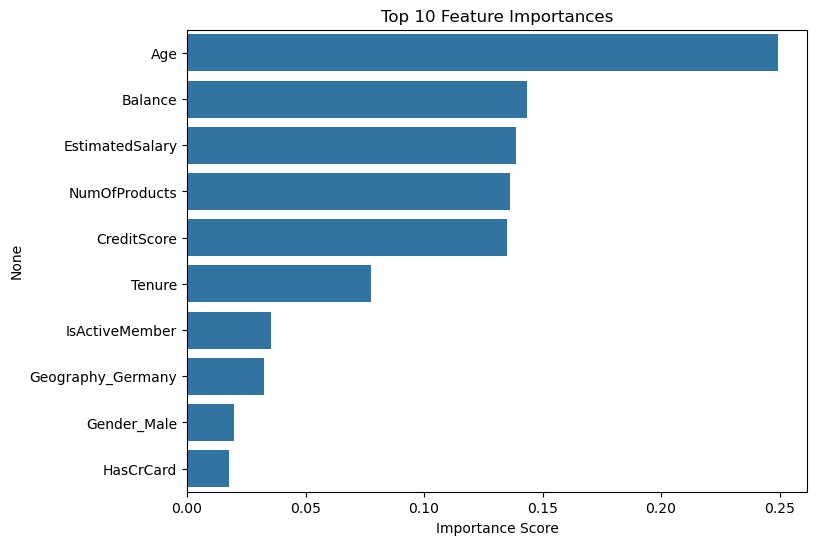

In [11]:
# Feature Importance
print("\nPlotting Feature Importance")
feature_names = (
    model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(['Geography', 'Gender'])
    .tolist() + list(X_train.select_dtypes(exclude='object').columns)
)

importances = model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


Feature importance analysis from the trained Random Forest model revealed the top contributors to churn prediction. Among the most influential features were customer Age, IsActiveMember status, and credit Score, alongside one hot encoded categories from Geography. Notably, Age and Activity Status showed the highest importance scores, aligning with earlier EDA findings that older and inactive customers are more prone to churn. Visualizing the top 10 features confirmed that both demographic and behavioral attributes play a critical role in the model’s decision-making process. These insights not only enhance model transparency but also guide potential areas for targeted retention strategies.

## CONCLUSION

This project successfully developed a machine learning model to predict customer churn at Beta Bank using structured client data. Through comprehensive exploratory analysis, we identified key behavioral and demographic trends notably, higher churn rates among older, inactive customers and regional disparities in attrition. Preprocessing included class balancing through upsampling, enabling the Random Forest model to generalize better across both churned and retained classes.

While the model achieved strong overall accuracy (~85%), its performance on the minority churn class was more modest (F1 Score ~0.58), highlighting the inherent challenge of identifying customers likely to leave. Confusion matrix analysis further emphasized the business risk of false negatives [missed churners] which could lead to lost revenue if not addressed. Feature importance analysis confirmed that Age, IsActiveMember, and Geography were primary drivers in churn prediction, providing actionable insights for Beta Bank's retention strategy.

Overall, this project demonstrates how predictive modeling, when supported by careful data exploration and class balancing techniques, can provide strategic value in customer lifecycle management. Future iterations may explore more advanced modeling techniques (e.g. gradient boosting, SHAP interpretability, or customer lifetime value analysis) to enhance both predictive accuracy and explainability.